In [1]:
%load_ext autoreload
%autoreload 2
from transformer import SpeechTransformer
import os
import torch
import random
import numpy as np
from torch.utils.data import DataLoader
from custom_dataset import SpectrogramDataset, BinaryDataset, create_sampler
from training_pipeline import repeat_training, set_seed, worker_init_fn
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
SEED = 42
set_seed(SEED)

In [3]:
data_path = "data/train/audio_transformed"
train_dataset = SpectrogramDataset(data_path, set_type=SpectrogramDataset.TRAIN, augmentation=True)
val_dataset = SpectrogramDataset(data_path, set_type=SpectrogramDataset.VAL)
test_dataset = SpectrogramDataset(data_path, set_type=SpectrogramDataset.TEST)

# train_dataset = BinaryDataset(data_path, set_type=SpectrogramDataset.TRAIN)
# val_dataset = BinaryDataset(data_path, set_type=SpectrogramDataset.VAL)
# test_dataset = BinaryDataset(data_path, set_type=SpectrogramDataset.TEST)

batch_size = 512
n_workers = 4
prefetch_factor = 2 if n_workers > 0 else None
persistent_workers = True if n_workers > 0 else False

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=persistent_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=persistent_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=persistent_workers)

In [4]:
alpha = 1
sampler = create_sampler(train_dataset, alpha=alpha)
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor,persistent_workers=persistent_workers, worker_init_fn=worker_init_fn)

In [5]:
dropout = 0.3
def init_transformer_1():
    return SpeechTransformer(nhead=4, num_layers=4, num_classes=11, dropout=dropout) # or 2

repetitions = 1
lr = 0.001
epochs = 100
tolerance = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_dir = "output/models/transformer"
history_dir = "output/history/transformer"

os.makedirs(model_dir, exist_ok=True)
os.makedirs(history_dir, exist_ok=True)

model_path = model_dir + "/transformer.pth"
history_path = history_dir + "/transformer.pkl"

repeat_training(repetitions, init_transformer_1, lr, model_path, history_path, epochs, train_loader, val_loader, test_loader, device, tolerance=tolerance)

training iteration: 1 of 1
starting training...
epoch: 1, training loss: 0.0047488396084872375, training accuracy: 9.13521766363921, training balanced accuracy: 9.126157668245598
epoch: 1, validation loss: 0.0049900788003888405, validation accuracy: 3.971756398940865, validation balanced accuracy: 9.090909090909092
model saved

epoch: 2, training loss: 0.004643825758709416, training accuracy: 12.431490761039775, training balanced accuracy: 12.488066706515122
epoch: 2, validation loss: 0.0053586032889316485, validation accuracy: 4.280670785525155, validation balanced accuracy: 10.173259451276694

epoch: 3, training loss: 0.004503852263387004, training accuracy: 15.74342311305982, training balanced accuracy: 15.701887459630203
epoch: 3, validation loss: 0.0051004236394708805, validation accuracy: 7.0609002647837595, validation balanced accuracy: 17.041881253982954

epoch: 4, training loss: 0.004418023012291478, training accuracy: 17.814359536486062, training balanced accuracy: 17.8323394

In [6]:
best_model = init_transformer_1()
best_model.to(device)
best_model.load_state_dict(torch.load("output/models/transformer/transformer_1.pth", weights_only=True))

<All keys matched successfully>

In [7]:
all_preds = []
best_model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output = best_model(x)
        _, predicted = torch.max(output, 1)
        # print(predicted)
        all_preds.extend(predicted.cpu().tolist())

pred_counts = Counter(all_preds)
sorted_pred_counts = dict(sorted(pred_counts.items()))
print(sorted_pred_counts)

{0: 515, 1: 665, 2: 516, 3: 575, 4: 329, 5: 737, 6: 628, 7: 394, 8: 476, 9: 352, 10: 1648}


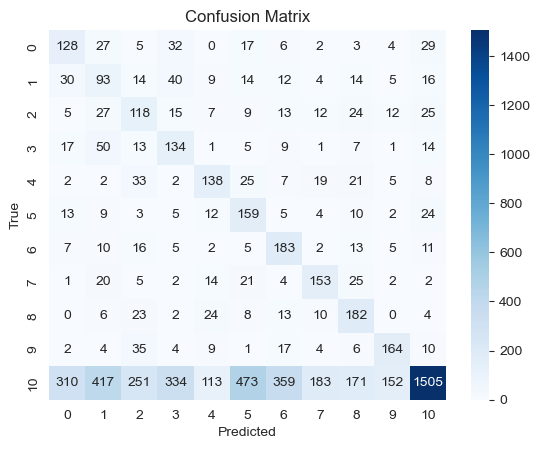

In [8]:
true_labels = []
predictions = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        output = best_model(x)
        _, predicted = torch.max(output, 1)
        
        true_labels.extend(y.cpu().tolist())
        predictions.extend(predicted.cpu().tolist())

unique_labels = np.unique(true_labels)
cm = confusion_matrix(true_labels, predictions, labels=unique_labels)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [10]:
unique_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [11]:
test_dataset.label_map

{'unknown': 10,
 'down': 0,
 'go': 1,
 'left': 2,
 'no': 3,
 'off': 4,
 'on': 5,
 'right': 6,
 'stop': 7,
 'up': 8,
 'yes': 9}